In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy.random as np

%matplotlib inline

# Create own dataset
## Data: Customer counts per date

In [64]:
np.seed(111)

In [65]:
def CreateDataSet(Number=1):
    Output = []
    
    for i in range(Number):
        #Create a list with Weekly Dates. See: W-MON
        rng = pd.date_range(start='1/1/2009', end='12/31/2012', freq='W-MON')
        
        np.seed(0)
        
        data = np.randint(low=25, high=1000, size=len(rng))
        
        status = [1, 2, 3]
        
        random_status = [status[np.randint(low=0, high=len(status))] for i in range(len(rng))]
        
        states = ['GA', 'FL', 'fl', 'NY', 'NJ', 'TX']
        
        random_states = [states[np.randint(low=0, high=len(states))] for i in range(len(rng))]
        
        dataset = zip(random_states, random_status, data, rng)
        
        Output.extend(dataset)
    
    return Output

In [66]:
dataset = CreateDataSet(4)

In [67]:
df = pd.DataFrame(dataset, columns=['State', 'Status', 'CustomerCount', 'StatusDate'])

In [68]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 836 entries, 0 to 835
Data columns (total 4 columns):
State            836 non-null object
Status           836 non-null int64
CustomerCount    836 non-null int64
StatusDate       836 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 26.2+ KB


In [69]:
df.head()

,State,Status,CustomerCount,StatusDate
0,fl,1,709,2009-01-05
1,TX,1,584,2009-01-12
2,FL,2,654,2009-01-19
3,fl,3,217,2009-01-26
4,TX,1,860,2009-02-02


## Save to Excel

In [70]:
df.to_excel('Lesson3.xlsx', index=False)

## Get data from Excel

In [71]:
df = pd.read_excel('Lesson3.xlsx', index_col='StatusDate')

In [72]:
df.head()

,State,Status,CustomerCount
StatusDate,,,
2009-01-05,fl,1,709
2009-01-12,TX,1,584
2009-01-19,FL,2,654
2009-01-26,fl,3,217
2009-02-02,TX,1,860


In [73]:
df.dtypes

State            object
Status            int64
CustomerCount     int64
dtype: object

In [74]:
df.index

DatetimeIndex(['2009-01-05', '2009-01-12', '2009-01-19', '2009-01-26',
               '2009-02-02', '2009-02-09', '2009-02-16', '2009-02-23',
               '2009-03-02', '2009-03-09',
               ...
               '2012-10-29', '2012-11-05', '2012-11-12', '2012-11-19',
               '2012-11-26', '2012-12-03', '2012-12-10', '2012-12-17',
               '2012-12-24', '2012-12-31'],
              dtype='datetime64[ns]', name=u'StatusDate', length=836, freq=None)

# Cleanup data and prepare for analysis

In [75]:
df['State'].unique()

array([u'fl', u'TX', u'FL', u'GA', u'NY', u'NJ'], dtype=object)

## Clean State Column

### Convert all states to uppercase

In [76]:
df['State'] = df.State.apply(lambda x: x.upper())

In [77]:
df['State'].unique()

array([u'FL', u'TX', u'GA', u'NY', u'NJ'], dtype=object)

### Change NJ to NY

In [78]:
mask = df['State'] == 'NJ'

# df['State'][mask] = 'NY' is avoided. TODO: Why?
df.loc[mask, 'State'] = 'NY'

In [79]:
df.State.unique()

array([u'FL', u'TX', u'GA', u'NY'], dtype=object)

## Plot the customer count on graph

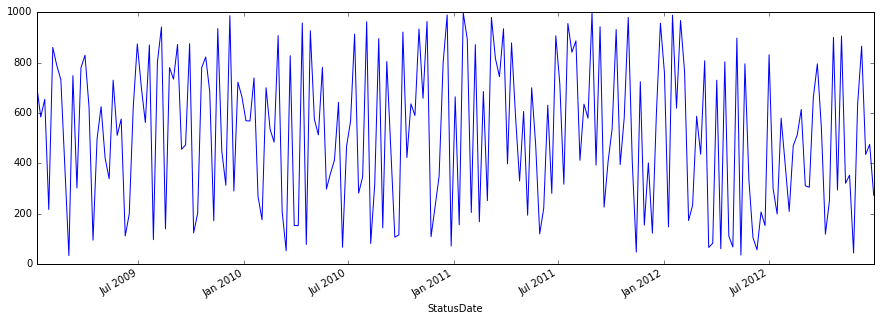

In [80]:
df['CustomerCount'].plot(figsize=(15,5))

## Grouping of data

In [81]:
# Reindex and bring StatusDate back to column instead of index
Daily = df.reset_index()

# Group all the customers according to state and the date
Daily = Daily.groupby(['State','StatusDate']).sum()

In [82]:
Daily.head()

Status  CustomerCount
State StatusDate                       
FL    2009-01-05       4           2836
      2009-01-19       8           2616
      2009-01-26      12            868
      2009-03-02      12            136
      2009-03-23       8           3116

In [83]:
# Remove the Status column as we do not need it
del Daily['Status']

In [84]:
Daily.head()

CustomerCount
State StatusDate               
FL    2009-01-05           2836
      2009-01-19           2616
      2009-01-26            868
      2009-03-02            136
      2009-03-23           3116

In [85]:
# Gives the insights to the how many level are there: 2 (State and Date)
# Daily.index

In [86]:
States = Daily.index.levels[0]
States

Index([u'FL', u'GA', u'NY', u'TX'], dtype='object', name=u'State')

In [87]:
Daily.index.levels[1]

DatetimeIndex(['2009-01-05', '2009-01-12', '2009-01-19', '2009-01-26',
               '2009-02-02', '2009-02-09', '2009-02-16', '2009-02-23',
               '2009-03-02', '2009-03-09',
               ...
               '2012-10-29', '2012-11-05', '2012-11-12', '2012-11-19',
               '2012-11-26', '2012-12-03', '2012-12-10', '2012-12-17',
               '2012-12-24', '2012-12-31'],
              dtype='datetime64[ns]', name=u'StatusDate', length=209, freq=None)

In [88]:
CreatePlotStateWise = lambda state: Daily.loc[state].plot(figsize=(15,5))

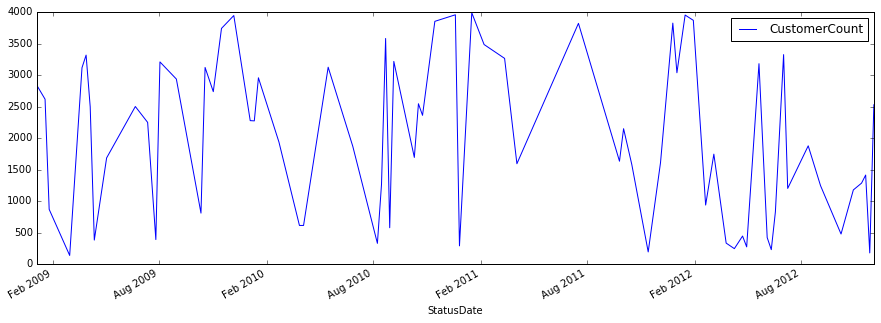

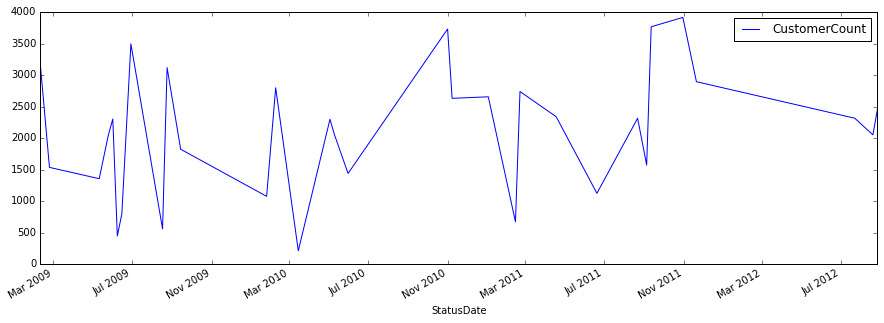

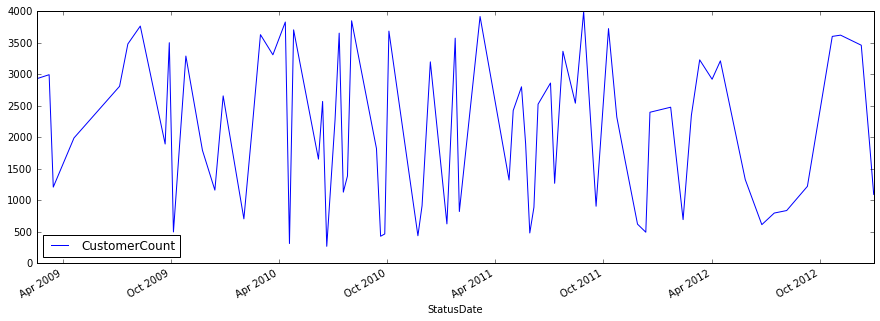

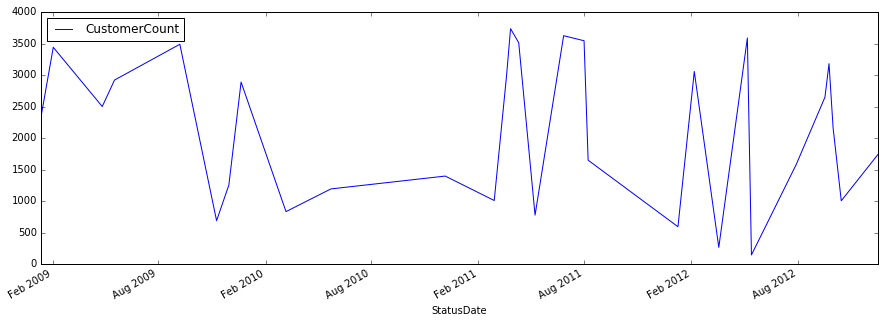

In [89]:
for state in States:
    CreatePlotStateWise(state)

## Group data by State, Year and Month

In [90]:
StateYearMonth = Daily.groupby([Daily.index.get_level_values(0),
                                Daily.index.get_level_values(1).year,
                                Daily.index.get_level_values(1).month])

Daily['Lower'] = StateYearMonth['CustomerCount'].transform(
                    lambda x: x.quantile(0.25) - (1.5*x.quantile(.75)-x.quantile(.25)))
Daily['Upper'] = StateYearMonth['CustomerCount'].transform(
                    lambda x: x.quantile(0.75) + (1.5*x.quantile(.75)-x.quantile(.25)))
Daily['Outlier'] = (Daily['CustomerCount'] < Daily['Lower']) | (Daily['CustomerCount'] > Daily['Upper'])

Daily = Daily[Daily['Outlier'] == False]

In [91]:
Daily.head()

CustomerCount   Lower   Upper Outlier
State StatusDate                                       
FL    2009-01-05           2836  -605.0  5073.0   False
      2009-01-19           2616  -605.0  5073.0   False
      2009-01-26            868  -605.0  5073.0   False
      2009-03-02            136 -1572.0  6414.0   False
      2009-03-23           3116 -1572.0  6414.0   False

### Create new data frame ALL having CustomerCount as all customers on particular date

In [92]:
# ALL = pd.DataFrame(Daily['CustomerCount']).reset_index().groupby(['StatusDate']).sum()
ALL = pd.DataFrame(Daily['CustomerCount'].groupby(Daily.index.get_level_values(1)).sum())

# YearMonth groupby object
# lambda x automatically uses first column
YearMonth = ALL.groupby([lambda x: x.year, lambda x: x.month])

# Saves Max customer count each month of each year
ALL['Max'] = YearMonth['CustomerCount'].transform(lambda x: x.max())
ALL.head()

,CustomerCount,Max
StatusDate,,
2009-01-05,2836,2836
2009-01-12,2336,2836
2009-01-19,2616,2836
2009-01-26,868,2836
2009-02-02,3440,3440


## Creating Goals for 2011, 2012, 2013

In [94]:
data = [2000,3000,4000]

In [128]:
# Create DataFrame
idx = pd.date_range(start='31/12/2011', end='31/12/2013', freq='A')
BHAG = pd.DataFrame(data, index = idx, columns=['BHAG'])
BHAG

,BHAG
2011-12-31,2000
2012-12-31,3000
2013-12-31,4000


In [110]:
# Combine BHAG and ALL
combined = pd.concat([ALL, BHAG], axis=0)
combined = combined.sort_index(axis=0)
combined.tail()

,BHAG,CustomerCount,Max
2012-12-17,NaN,1740.0,3460.0
2012-12-24,NaN,1900.0,3460.0
2012-12-31,NaN,1092.0,3460.0
2012-12-31,3000.0,NaN,NaN
2013-12-31,4000.0,NaN,NaN


## Plotting the BHAG and ALL

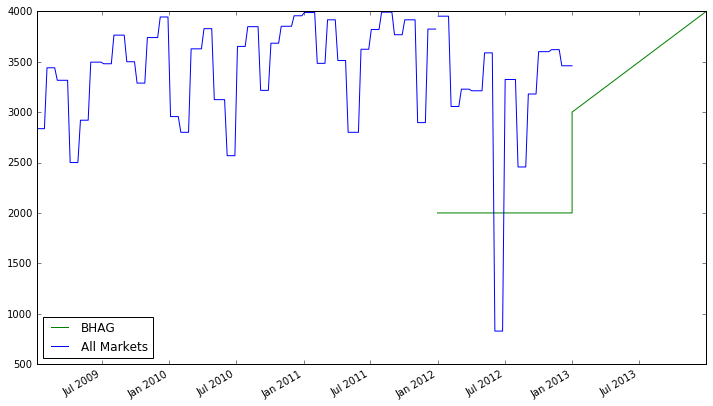

In [137]:
fig, axes = plt.subplots(figsize=(12,7))
combined['BHAG'].fillna(method='pad').plot(color='green')
combined['Max'].plot(color='blue', label='All Markets')

plt.legend(loc='best')

## Group by year

In [130]:
Year = combined.groupby(lambda x: x.year).max()

### Calculate per year percent change

In [132]:
Year['YR_PCT_CHANGE'] = Year['Max'].pct_change(periods=1)
Year

,BHAG,CustomerCount,Max,YR_PCT_CHANGE
2009,NaN,3944.0,3944.0,NaN
2010,NaN,3956.0,3956.0,0.003043
2011,2000.0,3992.0,3992.0,0.009100
2012,3000.0,3952.0,3952.0,-0.010020
2013,4000.0,NaN,NaN,NaN


### Calculate next year customer count by assuming that percent change remains same

In [135]:
(1 + Year.ix[2012, 'YR_PCT_CHANGE']) * (Year.ix[2012, 'Max'])

3912.4008016032062